In [1]:
#Imports
import pandas as pd
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import xgboost as xgb
from PIL import Image, ImageOps
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv("NCAA Champion RawData.csv")
print(list(df.columns))

['Season', '#', 'Team/Season', 'Team', 'Conference', 'Conference/Season', 'Bracket Region', 'Bracket Region/Season', 'round make', 'champion share', 'make tournament', 'Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'Top_4_Seed_True', 'sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L5Y cs', 'sum conf L8Y cs', 'sum conf L10Y cs', 'sum school L1Y cs', 'sum school L3Y cs', 'sum school L5Y cs', 'sum school L8Y cs', 'sum school L10Y cs', 'sum school champion', 'sum school Finals apps', 'sum school F4 apps', 'sum school E8 apps', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'sum mm tour games', '

In [6]:
data_columns = ['Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'Top_4_Seed_True', 'sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L5Y cs', 'sum conf L8Y cs', 'sum conf L10Y cs', 'sum school L1Y cs', 'sum school L3Y cs', 'sum school L5Y cs', 'sum school L8Y cs', 'sum school L10Y cs', 'sum school champion', 'sum school Finals apps', 'sum school F4 apps', 'sum school E8 apps', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 'sum career games', 'sum polls made', 'poll_Pre 1', 'poll_Week 2', 'poll_Week 3', 'poll_Week 4', 'poll_Week 5', 'poll_Week 6', 'poll_Week 7', 'poll_Week 8', 'poll_Week 9', 'poll_Week 10', 'poll_Week 11', 'poll_Week 12', 'poll_Week 13', 'poll_Week 14', 'poll_Week 15', 'poll_Week 16', 'poll_Week 17', 'poll_Week 18', 'poll_avg', 'top_12_Week 12', 'team_rating_avg_custom', 'max_player_rating_custom', 'cf_rating_custom', 'bracket_region_rating_custom']

df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [221]:
correlation_matrix = data.corr()

correlation_threshold = .9

columns_to_remove = set()
print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)

Columns to be Removed:
sum conf L5Y cs (correlated with sum conf L3Y cs): 0.96
sum conf L8Y cs (correlated with sum conf L3Y cs): 0.91
sum school L8Y cs (correlated with sum school L5Y cs): 0.93
sum school L10Y cs (correlated with sum school L5Y cs): 0.90
eFG% (correlated with TS%): 0.94
HOB (correlated with AST%): 0.97
TOV (correlated with TOV%): 0.90
SPG (correlated with STL%): 0.93
BPG (correlated with BLK%): 0.93
MOV (correlated with eDiff): 0.99
Win % (correlated with L's): -0.92
FGM (correlated with PPG): 0.91
3PA (correlated with 3PM): 0.92
FTA (correlated with FTM): 0.93
sum career games (correlated with sum cf reg games): 0.99
poll_avg (correlated with sum polls made): 0.91
poll_Week 2 (correlated with poll_Pre 1): 0.99
poll_Week 3 (correlated with poll_Pre 1): 0.94
poll_Week 5 (correlated with poll_Week 4): 0.95
poll_Week 6 (correlated with poll_Week 4): 0.91
poll_Week 8 (correlated with poll_Week 7): 0.98
poll_Week 9 (correlated with poll_Week 7): 0.95
poll_avg (correlated w

In [222]:
print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'Top_4_Seed_True', 'sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L10Y cs', 'sum school L1Y cs', 'sum school L3Y cs', 'sum school L5Y cs', 'sum school champion', 'sum school Finals apps', 'sum school F4 apps', 'sum school E8 apps', 'TS%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'Techs', 'Ast/TO', 'Stl/TO', 'FT/FGA', 'W's', 'L's', 'GP', 'MPG', 'PPG', 'FGA', 'FG%', '3PM', '3P%', 'FTM', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'PF', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 'sum polls made', 'poll_Pre 1', 'poll_Week 4', 'poll_Week 7', 'poll_Week 10', 'poll_Week 13', 'poll_Week 16', 'top_12_Week 12', 'team_rating_avg_custom', 'cf_rating_custom', 'bracket_region_rating_custom'

Columns that were removed:
'poll_Week 9', 'poll_We

In [7]:
#best features 12/24/23

features = ['Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'sum conf L1Y cs', 
            'sum conf L3Y cs', 'sum conf L10Y cs', 'sum school L1Y cs', 'sum school L3Y cs', 'sum school L5Y cs',
            'sum school champion', 'sum school Finals apps', 'sum school F4 apps', 'sum school E8 apps', 'TS%', 
            'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg',
            'MOV', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game',
            'Techs', 'Ast/TO', 'Stl/TO', 'FT/FGA', 'Win %', 'GP', 'MPG', 'PPG', 'FGA', 'FG%', '3PM', '3P%', 'FTM',
            'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'PF', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 
            'sum polls made', 'poll_Pre 1', 'poll_Week 4', 'poll_Week 7', 'poll_Week 10', 'poll_Week 13', 'poll_Week 16',
            'top_12_Week 12', 'team_rating_avg_custom', 'cf_rating_custom', 'bracket_region_rating_custom']

            
num_features = len(features)

print(f"Number of features: {num_features}")

Number of features: 73


# new bf

features = ['Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'sum conf L1Y cs', 
            'sum conf L3Y cs', 'sum conf L10Y cs', 'sum school L1Y cs', 'sum school L3Y cs', 'sum school L5Y cs',
            'sum school champion', 'sum school Finals apps', 'sum school F4 apps', 'sum school E8 apps', 'TS%', 
            'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg',
            'MOV', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game',
            'Techs', 'Ast/TO', 'Stl/TO', 'FT/FGA', 'Win %', 'GP', 'MPG', 'PPG', 'FGA', 'FG%', '3PM', '3P%', 'FTM',
            'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'PF', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 
            'sum polls made', 'poll_Pre 1', 'poll_Week 4', 'poll_Week 7', 'poll_Week 10', 'poll_Week 13', 'poll_Week 16',
            'top_12_Week 12', 'team_rating_avg_custom', 'cf_rating_custom', 'bracket_region_rating_custom', 'poll_avg', 'SPG']

            
num_features = len(features)

print(f"Number of features: {num_features}")

#set features 1:

features = ['sum conf L1Y cs', 'sum conf L3Y cs', 'sum conf L8Y cs', 'sum school L1Y cs', 'sum school L2Y cs',
            'sum school L4Y cs', 'sum school L8Y cs', 'sum school champion', 'sum school E8 apps', 'sum school F4 apps',
            'sum school Finals apps', 'TS%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 
            'FIC40', 'ORtg', 'DRtg', 'MOV', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl',
            '5 Blk', 'High Game', 'Techs', 'Ast/TO', 'Stl/TO', 'FT/FGA', 'Win %', 'GP', 'MPG', 'PPG', 'FGA', 'FG%', 
            '3PM', '3P%', 'FTM', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'PF', 'Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3',
            'Seed_4', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 'sum polls made', 
            'poll_Pre 1', 'poll_Week 4', 'poll_Week 7', 'poll_Week 10', 'poll_Week 13', 'poll_Week 16', 'top_12_Week 12', 'team_rating_avg_custom', 'cf_rating_custom', 'region_rating_custom']



#best features 12/24/23

features = ['Seed_Tournament', 'Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'sum conf L1Y cs', 
            'sum conf L3Y cs', 'sum conf L10Y cs', 'sum school L1Y cs', 'sum school L3Y cs', 'sum school L5Y cs',
            'sum school champion', 'sum school Finals apps', 'sum school F4 apps', 'sum school E8 apps', 'TS%', 
            'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg',
            'MOV', 'eDiff', 'Poss', 'Pace', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game',
            'Techs', 'Ast/TO', 'Stl/TO', 'FT/FGA', 'Win %', 'GP', 'MPG', 'PPG', 'FGA', 'FG%', '3PM', '3P%', 'FTM',
            'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'PF', 'sum mm tour games', 'sum cf tour games', 'sum cf reg games', 
            'sum polls made', 'poll_Pre 1', 'poll_Week 4', 'poll_Week 7', 'poll_Week 10', 'poll_Week 13', 'poll_Week 16',
            'top_12_Week 12', 'team_rating_avg_custom', 'cf_rating_custom', 'bracket_region_rating_custom']

            
num_features = len(features)

print(f"Number of features: {num_features}")

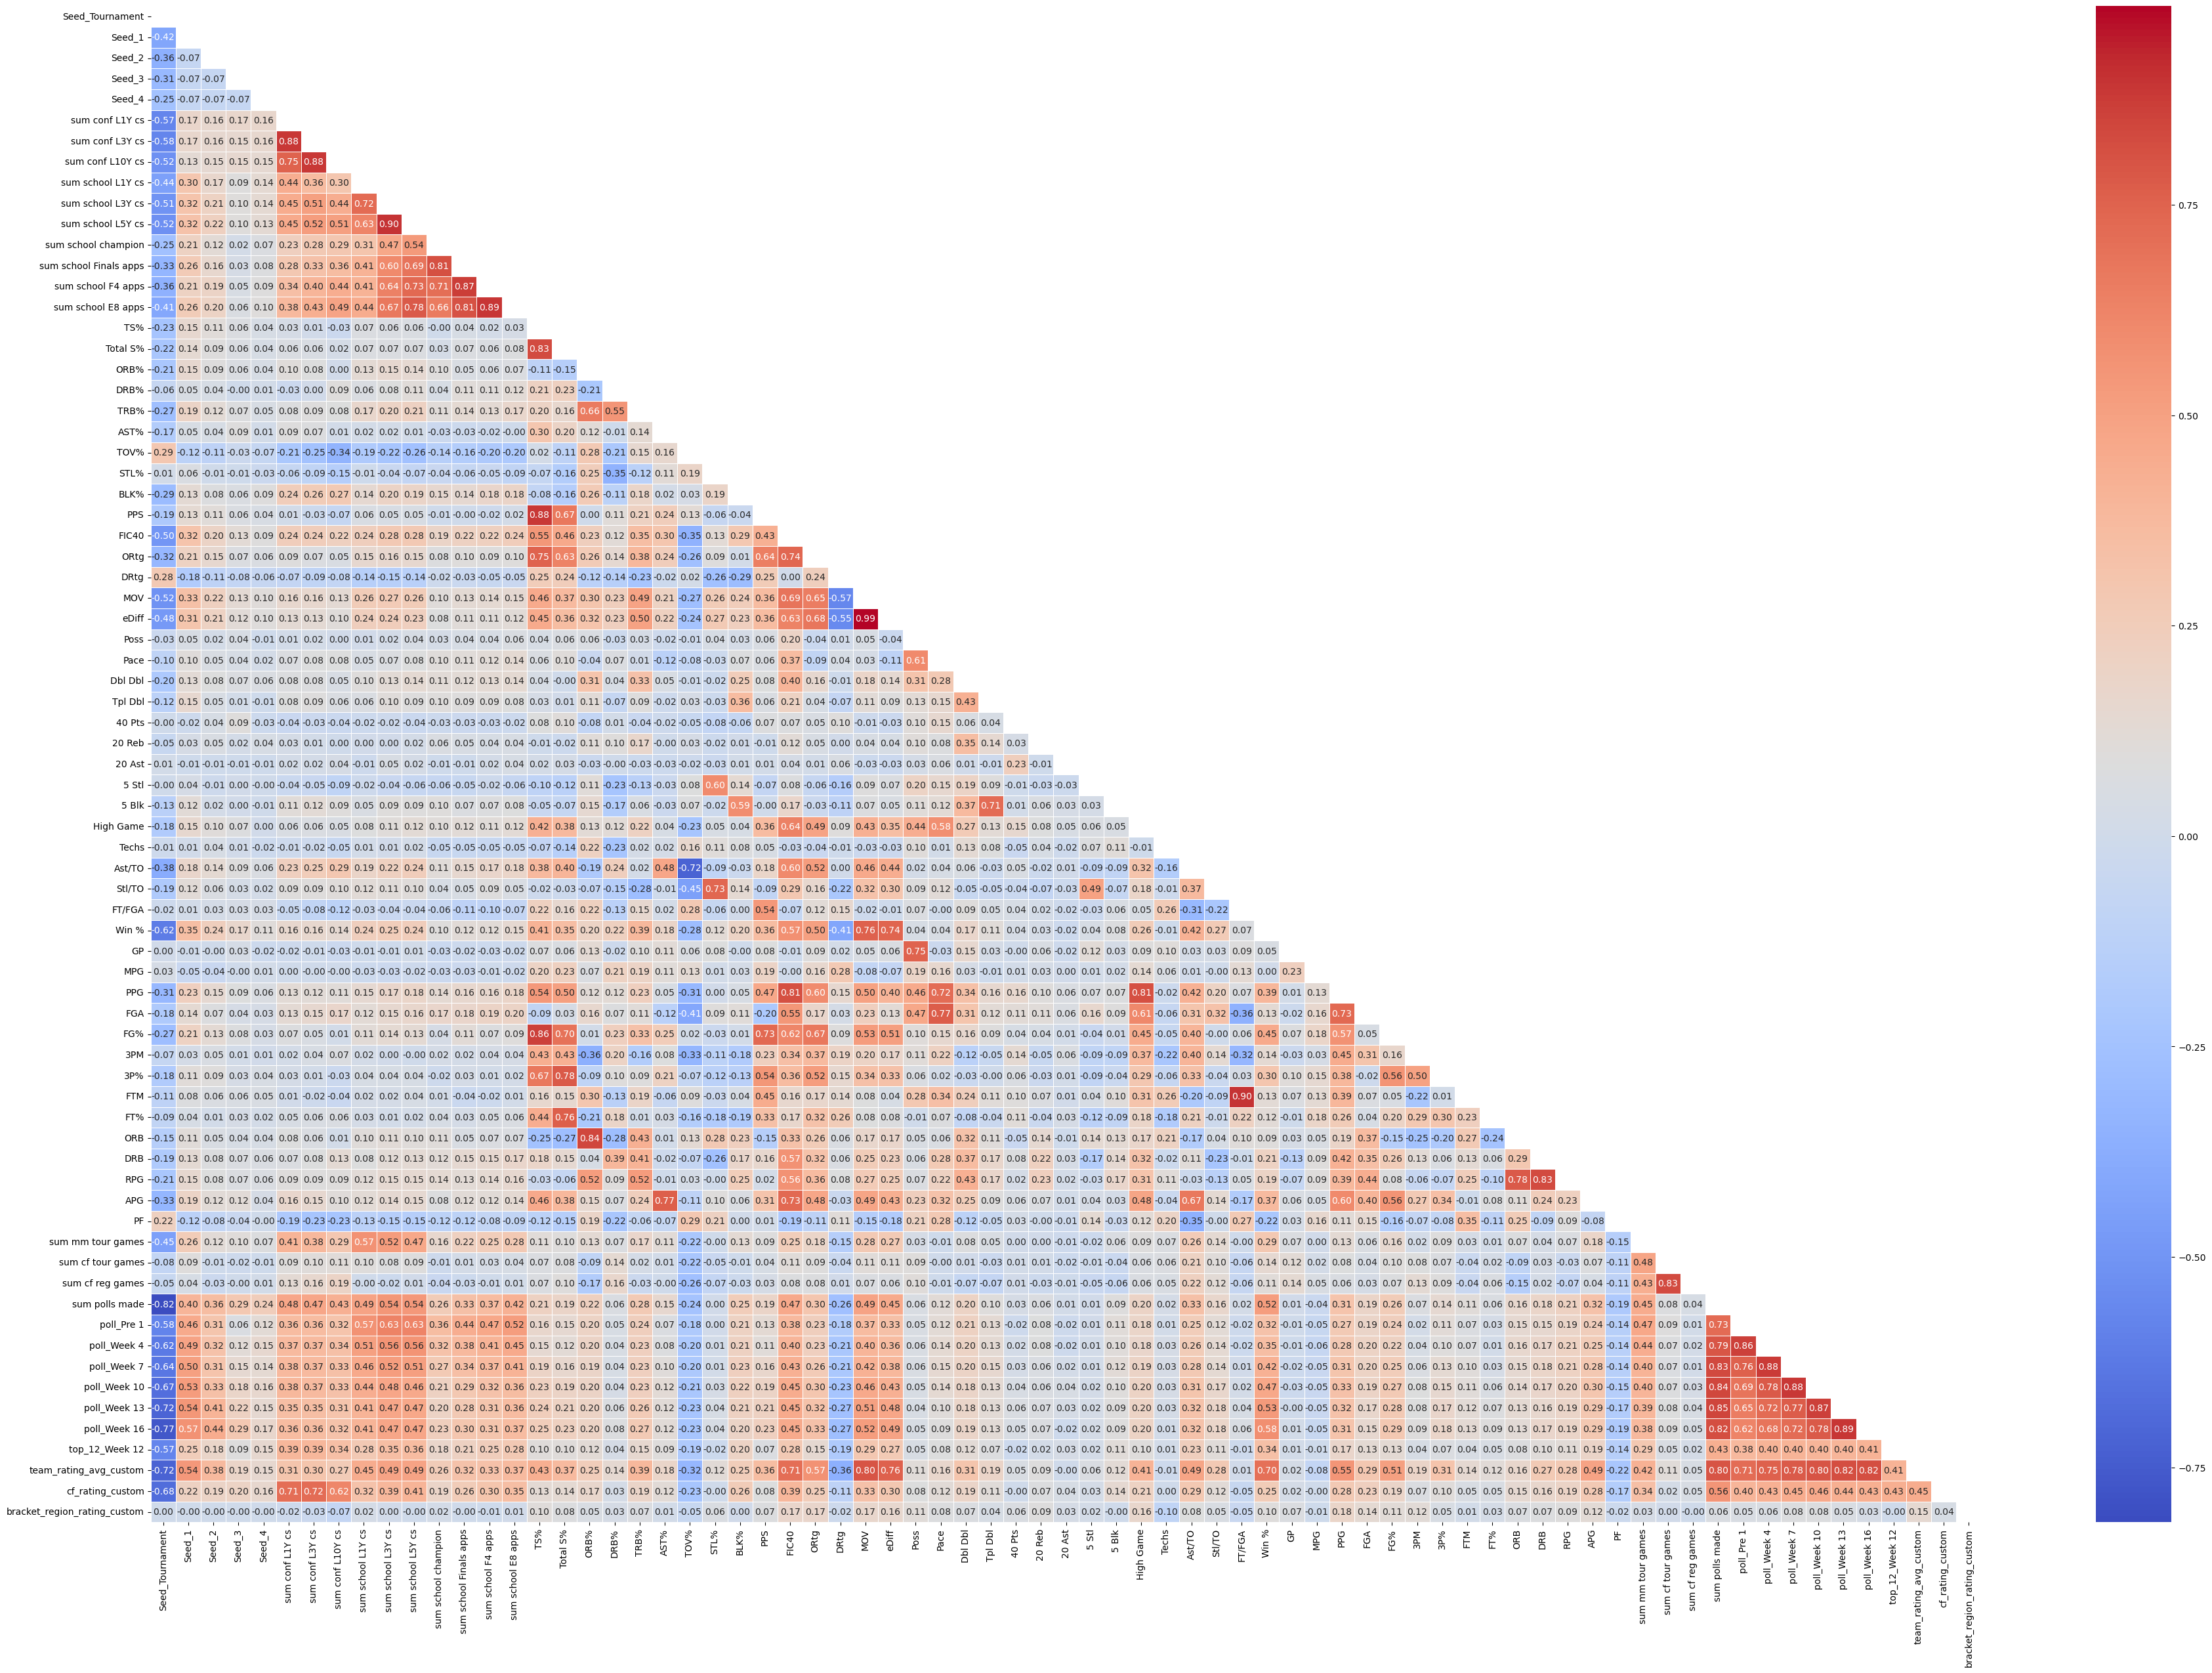

In [8]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(45, 30))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

In [226]:
train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

# Model parameters
rf = RandomForestRegressor(n_estimators=5, random_state=15, min_samples_split=5, max_depth=None)
rf.fit(train[features], train["champion share"])

# Predicting
predictions = rf.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make tournament"] == True]  # Modify this line
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

# Error metrics
mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)

print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")

# Feature importance
f_list = list(features)
f_importance = pd.Series(rf.feature_importances_, index=f_list).sort_values(ascending=False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")

frame_playoff = test[test["make tournament"] == True]  # Modify this line

predictions = rf.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)
frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)
frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.head(5))

Error Metrics: 

PT MAE:  0.13811517860854539
PT MSE:  0.04249328707716232
PT RMSE:  0.20613899940856006
-----------------------------------------------------------------------------

Feature Importance: 

Seed_Tournament           0.347885
team_rating_avg_custom    0.071327
poll_Pre 1                0.036375
DRtg                      0.022151
3P%                       0.021881
FG%                       0.019251
sum conf L3Y cs           0.019042
BLK%                      0.017529
TS%                       0.017169
PF                        0.015924
ORtg                      0.015219
sum polls made            0.014851
FT/FGA                    0.013762
3PM                       0.013134
sum conf L10Y cs          0.012656
FTM                       0.011882
DRB%                      0.011847
Win %                     0.011636
poll_Week 4               0.011231
poll_Week 10              0.011136
dtype: float64
-----------------------------------------------------------------------------



In [227]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(4)
print("Ranking Accuracy (Top 4):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(4)

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Top 4: ", ap)

Ranking Accuracy (Top 4):

   Season_x              Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2023       Connecticut          1.000000                    0.466667     1      2023          1.000000                    0.466667               4
1      2023   San Diego State          0.833333                    0.200000     2      2023          0.833333                    0.200000              22
2      2023        Miami (FL)          0.666667                    0.200000     3      2023          0.666667                    0.200000              21
3      2023  Florida Atlantic          0.666667                    0.083889     4      2023          0.666667                    0.083889              42

PT AP Top 4:  0.1442099567099567


In [228]:
all_predictions = []
aps = []

target_seasons = [2021, 2022, 2023]

# Backtesting
for season in target_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion share'])
    predictions = rf.predict(test[features])
    predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share"]], predictions], axis=1)
    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)
    print(f"AP for Season {season}: {ap}")

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average MAE: {average_mae}")
print(f"Average MSE: {average_mse}")
print(f"Average RMSE: {average_rmse}")
print(f"Average AP: {average_ap}")
print("=============================================================================")

AP for Season 2021: 0.7291666666666666
AP for Season 2022: 0.24519230769230768
AP for Season 2023: 0.1442099567099567

Average Error Metrics Across All Seasons:
Average MAE: 0.14461312830282905
Average MSE: 0.043515410976074136
Average RMSE: 0.2083548333082431
Average AP: 0.37285631035631034


In [218]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, average_precision_score

target_variable = 'champion share'

train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

models = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [5, 10, 15, 25, 100],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'random_state': [1, 5, 10, 15]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [5, 10, 15, 25, 100],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1],
            'random_state': [1, 5, 10, 15]
        }
    }
}

from tqdm import tqdm
results = {}
for model_name, model_info in models.items():
    param_grid = ParameterGrid(model_info['params'])
    best_mae = np.inf
    best_params = None  

    for params in tqdm(param_grid, desc=f"Grid search for {model_name}", position=0, leave=True):
        model = model_info['model'].set_params(**params)
        model.fit(train[features], train[target_variable])
        predictions = model.predict(test[features])

        # Calculate MAE
        mae = mean_absolute_error(test[target_variable], predictions)

        if mae < best_mae:
            best_mae = mae
            best_params = params  

    final_model = model_info['model'].set_params(**best_params)
    final_model.fit(train[features], train[target_variable])

    test['predicted champion share'] = final_model.predict(test[features])

    ap = find_ap(test)
    
    print("=============================================================================\n")
    print(f"Model: {model_name}")
    print(f"PT AP Top 4: {ap}")
    print(f"MAE: {best_mae}")
    print(f"Best Parameters: {best_params}")
    print("-----------------------------------------------------------------------------\n")

    results[model_name] = {
        'MAE': best_mae,
        'Best_Params': best_params,
        'Average_Precision_Top_4': ap
    }

    completion_percentage = (len(results) / len(models)) * 100
    print(f"Model {model_name} completed. {completion_percentage:.2f}% done.")

print("Grid search and evaluation completed.")

Grid search for RandomForest: 100%|██████████| 240/240 [04:47<00:00,  1.20s/it]



Model: RandomForest
PT AP Top 4: 0.1111111111111111
MAE: 0.1286356991583202
Best Parameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 5, 'random_state': 1}
-----------------------------------------------------------------------------

Model RandomForest completed. 50.00% done.


Grid search for XGBoost: 100%|██████████| 160/160 [00:08<00:00, 19.65it/s]


Model: XGBoost
PT AP Top 4: 0.09090909090909091
MAE: 0.14187743915061207
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'random_state': 1}
-----------------------------------------------------------------------------

Model XGBoost completed. 100.00% done.
Grid search and evaluation completed.


### Random Forest:

In [89]:
rf = RandomForestRegressor(max_depth=None, min_samples_split=5, n_estimators=5, random_state=5) L10 2.7 | L3 2.3 | L4 2.0 SCORE: 2.33
Champion AP for Season 2015: 0.25 | Reciprocal: 4.0
Champion AP for Season 2016: 0.04 | Reciprocal: 24.0
Champion AP for Season 2017: 0.25 | Reciprocal: 4.0
Champion AP for Season 2018: 0.09 | Reciprocal: 11.0
Champion AP for Season 2019: 1.0 | Reciprocal: 1.0
Champion AP for Season 2021: 0.5 | Reciprocal: 2.0
Champion AP for Season 2022: 0.5 | Reciprocal: 2.0
Champion AP for Season 2023: 0.33 | Reciprocal: 3.0

Top 16 AP for Season 2015: 0.66 | Reciprocal: 1.52
Top 16 AP for Season 2016: 0.55 | Reciprocal: 1.83
Top 16 AP for Season 2017: 0.73 | Reciprocal: 1.37
Top 16 AP for Season 2018: 0.38 | Reciprocal: 2.66
Top 16 AP for Season 2019: 0.82 | Reciprocal: 1.22
Top 16 AP for Season 2021: 0.51 | Reciprocal: 1.97
Top 16 AP for Season 2022: 0.69 | Reciprocal: 1.45
Top 16 AP for Season 2023: 0.69 | Reciprocal: 1.44

Average Error Metrics Across All Seasons:
=============================================================================
BT Average Top 16 AP: 0.63 | Reciprocal: 1.59
BT Max Top 16 AP: 0.38 | Reciprocal: 2.66
BT Min Top 16 AP: 0.82 | Reciprocal: 1.22
=============================================================================

rf = RandomForestRegressor(max_depth=None, min_samples_split=5, n_estimators=4, random_state=5) L10 2.88 | L3 3.0 | L4 2.5 SCORE: 2.793
Champion AP for Season 2015: 0.33 | Reciprocal: 3.0
Champion AP for Season 2016: 0.05 | Reciprocal: 19.0
Champion AP for Season 2017: 0.25 | Reciprocal: 4.0
Champion AP for Season 2018: 0.06 | Reciprocal: 16.0
Champion AP for Season 2019: 1.0 | Reciprocal: 1.0
Champion AP for Season 2021: 0.33 | Reciprocal: 3.0
Champion AP for Season 2022: 0.25 | Reciprocal: 4.0
Champion AP for Season 2023: 0.5 | Reciprocal: 2.0

rf = RandomForestRegressor(max_depth=None, min_samples_split=2, n_estimators=5, random_state=5)  L10 2.69 | L3 2.3 | L4 2.0 SCORE 2.33
Champion AP for Season 2015: 0.25 | Reciprocal: 4.0
Champion AP for Season 2016: 0.03 | Reciprocal: 34.0
Champion AP for Season 2017: 0.25 | Reciprocal: 4.0
Champion AP for Season 2018: 0.11 | Reciprocal: 9.0
Champion AP for Season 2019: 1.0 | Reciprocal: 1.0
Champion AP for Season 2021: 0.5 | Reciprocal: 2.0
Champion AP for Season 2022: 0.5 | Reciprocal: 2.0
Champion AP for Season 2023: 0.33 | Reciprocal: 3.0

Top 16 AP for Season 2015: 0.65 | Reciprocal: 1.54
Top 16 AP for Season 2016: 0.58 | Reciprocal: 1.71
Top 16 AP for Season 2017: 0.62 | Reciprocal: 1.61
Top 16 AP for Season 2018: 0.4 | Reciprocal: 2.5
Top 16 AP for Season 2019: 0.79 | Reciprocal: 1.27
Top 16 AP for Season 2021: 0.56 | Reciprocal: 1.78
Top 16 AP for Season 2022: 0.65 | Reciprocal: 1.53
Top 16 AP for Season 2023: 0.66 | Reciprocal: 1.52

Average Error Metrics Across All Seasons:
=============================================================================
BT Average Top 16 AP: 0.61 | Reciprocal: 1.63
BT Max Top 16 AP: 0.4 | Reciprocal: 2.5
BT Min Top 16 AP: 0.79 | Reciprocal: 1.27
=============================================================================


rf = RandomForestRegressor(max_depth=None, min_samples_split=2, n_estimators=10, random_state=15) L10 1.97 | L3 5.7 | L4 5 SCORE 4.22
Champion AP for Season 2015: 1.0 | Reciprocal: 1.0
Champion AP for Season 2016: 0.06 | Reciprocal: 16.0
Champion AP for Season 2017: 0.25 | Reciprocal: 4.0
Champion AP for Season 2018: 1.0 | Reciprocal: 1.0
Champion AP for Season 2019: 0.33 | Reciprocal: 3.0
Champion AP for Season 2021: 1.0 | Reciprocal: 1.0
Champion AP for Season 2022: 0.08 | Reciprocal: 13.0
Champion AP for Season 2023: 0.33 | Reciprocal: 3.0

rf = RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=9, random_state=15) L10 1.97 | L3 4.67 | L4 4 SCORE 3.55
Champion AP for Season 2015: 0.17 | Reciprocal: 6.0
Champion AP for Season 2016: 0.06 | Reciprocal: 16.0
Champion AP for Season 2017: 0.25 | Reciprocal: 4.0
Champion AP for Season 2018: 1.0 | Reciprocal: 1.0
Champion AP for Season 2019: 0.5 | Reciprocal: 2.0
Champion AP for Season 2021: 1.0 | Reciprocal: 1.0
Champion AP for Season 2022: 0.08 | Reciprocal: 12.0
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0


#rf = RandomForestRegressor(max_depth=None, min_samples_split=5, n_estimators=7, random_state=5) BEST .49 L10 almost L4 chps correct pred

SyntaxError: invalid syntax (2570104857.py, line 1)

In [9]:

train = df[df["Season"] < 2023].copy()
test = df[df["Season"] == 2023].copy()


sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

rf = RandomForestRegressor(max_depth=None, min_samples_split=5, n_estimators=7, random_state=5) 
rf.fit(train[features], train["champion share"])


predictions = rf.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make tournament"] == True]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])


mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


f_list = list(features)
f_importance = pd.Series(rf.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")


frame_playoff = test[test["make tournament"] == True]


predictions = rf.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)


frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)


frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])


print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.head(5))

Error Metrics: 

PT MAE:  0.14086627060177234
PT MSE:  0.04013866402198703
PT RMSE:  0.20034636014159835
-----------------------------------------------------------------------------

Feature Importance: 

Seed_Tournament           0.229329
poll_Week 16              0.098816
team_rating_avg_custom    0.076098
poll_Pre 1                0.031891
poll_Week 4               0.023024
sum polls made            0.022067
ORB%                      0.021254
FT%                       0.021044
sum cf tour games         0.020894
DRB%                      0.016866
MOV                       0.016647
FG%                       0.016578
FT/FGA                    0.015576
BLK%                      0.015255
AST%                      0.014427
FTM                       0.013651
DRtg                      0.013389
3PM                       0.013167
Win %                     0.012584
RPG                       0.010698
dtype: float64
-----------------------------------------------------------------------------



### RandomForest Champion Evaluation:

In [10]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(1) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x         Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2023  Connecticut               1.0                     0.52381     1      2023               1.0                     0.52381               1

PT AP Champion:  1.0


In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



all_predictions = []
aps = []

backtest_seasons = [2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023]
combined_predictions = pd.DataFrame(columns=['predicted champion share', 'champion share', 'Team', 'Season', 'Team/Season'])

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share", "Season"]], predictions_df], axis=1)

    frame_playoff['Team/Season'] = frame_playoff['Team'] + ' ' + frame_playoff['Season'].astype(str)
    combined_predictions = pd.concat([combined_predictions, frame_playoff], ignore_index=True)

    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)

    reciprocal_ap = 1 / ap
    print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

    aps.append(ap)

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted champion share", ascending=False).head(5)
    
    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted champion share", "champion share"]])

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Champion AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Champion AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Champion AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Champion AP for Season 2015: 0.7 | Reciprocal: 1.43
Champion AP for Season 2016: 0.58 | Reciprocal: 1.73
Champion AP for Season 2017: 0.7 | Reciprocal: 1.42
Champion AP for Season 2018: 0.44 | Reciprocal: 2.27
Champion AP for Season 2019: 0.83 | Reciprocal: 1.21
Champion AP for Season 2021: 0.59 | Reciprocal: 1.69
Champion AP for Season 2022: 0.63 | Reciprocal: 1.59
Champion AP for Season 2023: 0.56 | Reciprocal: 1.79

Top 5 Predicted Teams for Season 2015:
               Team  predicted champion share  champion share
449       Wisconsin                  0.693878        0.833333
450        Kentucky                  0.626984        0.666667
453         Arizona                  0.579365        0.500000
457  North Carolina                  0.534014        0.333333
448            Duke                  0.507937        1.000000

Top 5 Predicted Teams for Season 2016:
               Team  predicted champion share  champion share
388          Kansas                  0.550652        0.500000
38

### Random Forest Top 16 Teams Evaluation:

In [13]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(16) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(16) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

                Team  champion share_x  Season_x  predicted champion share_x          Team/Season_x  Rank  champion share_y  Season_y  predicted champion share_y          Team/Season_y  Predicted Rank
0        Connecticut          1.000000      2023                    0.523810       Connecticut 2023     1          1.000000      2023                    0.523810       Connecticut 2023               1
1    San Diego State          0.833333      2023                    0.257143   San Diego State 2023     2          0.833333      2023                    0.257143   San Diego State 2023              18
2         Miami (FL)          0.666667      2023                    0.142857        Miami (FL) 2023     3          0.666667      2023                    0.142857        Miami (FL) 2023              31
3   Florida Atlantic          0.666667      2023                    0.091270  Florida Atlantic 2023     4          0.666667      2023                    0.091270  Flo

In [263]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


all_predictions = []
aps = []

backtest_seasons = [2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023]
combined_predictions = pd.DataFrame(columns=['predicted champion share', 'champion share', 'Team', 'Season', 'Team/Season'])

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share", "Season"]], predictions_df], axis=1)


    frame_playoff['Team/Season'] = frame_playoff['Team'] + ' ' + frame_playoff['Season'].astype(str)
    combined_predictions = pd.concat([combined_predictions, frame_playoff], ignore_index=True)

    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)

    reciprocal_ap = 1 / ap
    print(f"Top 16 AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

    aps.append(ap)


for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted champion share", ascending=False).head(16)

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Top 16 AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Top 16 AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Top 16 AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Top 16 AP for Season 2015: 0.7 | Reciprocal: 1.43
Top 16 AP for Season 2016: 0.58 | Reciprocal: 1.73
Top 16 AP for Season 2017: 0.7 | Reciprocal: 1.42
Top 16 AP for Season 2018: 0.44 | Reciprocal: 2.27
Top 16 AP for Season 2019: 0.83 | Reciprocal: 1.21
Top 16 AP for Season 2021: 0.59 | Reciprocal: 1.69
Top 16 AP for Season 2022: 0.63 | Reciprocal: 1.59
Top 16 AP for Season 2023: 0.56 | Reciprocal: 1.79

Average Error Metrics Across All Seasons:
BT Average Top 16 AP: 0.63 | Reciprocal: 1.59
BT Max Top 16 AP: 0.44 | Reciprocal: 2.27
BT Min Top 16 AP: 0.83 | Reciprocal: 1.21


### XGBoost

In [105]:
from xgboost import XGBRegressor

train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

#Model: XGBoost
#PT AP Top 4: 0.09090909090909091
#MAE: 0.1430522999329635
#Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 1}


xgb = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=5)
xgb.fit(train[features], train["champion share"])

predictions = xgb.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make tournament"] == True]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])

mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


f_list = list(features)
f_importance = pd.Series(xgb.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")


frame_playoff = test[test["make tournament"] == True]

predictions = xgb.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)

frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)

frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.to_string())

Error Metrics: 

PT MAE:  0.14406639007246966
PT MSE:  0.0410523188600785
PT RMSE:  0.20261371834127742
-----------------------------------------------------------------------------

Feature Importance: 

Seed_Tournament           0.126750
poll_Week 16              0.095681
team_rating_avg_custom    0.051102
sum polls made            0.034141
poll_Week 4               0.033023
APG                       0.029554
poll_Pre 1                0.027624
3P%                       0.023575
TRB%                      0.023381
eDiff                     0.022628
sum cf tour games         0.021697
sum conf L3Y cs           0.020160
sum school F4 apps        0.019917
Stl/TO                    0.018704
ORB%                      0.016397
MPG                       0.016165
TOV%                      0.015995
sum school E8 apps        0.015897
FG%                       0.014643
PF                        0.014373
dtype: float32
-----------------------------------------------------------------------------

F

In [16]:
combined_predictions.to_csv('L4S Preds.csv', index=False)

In [27]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming df, features, and rf are defined in your code

all_predictions = []
aps = []

backtest_seasons = [2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023]
combined_predictions = pd.DataFrame(columns=['predicted champion share', 'champion share', 'Team', 'Season', 'Team/Season'])

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
    frame_playoff = pd.concat([test[["Team", "champion share", "Season"]], predictions_df], axis=1)


    frame_playoff['Team/Season'] = frame_playoff['Team'] + ' ' + frame_playoff['Season'].astype(str)
    combined_predictions = pd.concat([combined_predictions, frame_playoff], ignore_index=True)

    all_predictions.append(frame_playoff)
    ap = find_ap(frame_playoff)
    aps.append(ap)

    reciprocal_ap = 1 / ap
    print(f"Top 16 AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

    aps.append(ap)


for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted champion share", ascending=False).head(16)

average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Top 16 AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Top 16 AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Top 16 AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Top 16 AP for Season 2015: 0.59 | Reciprocal: 1.7
Top 16 AP for Season 2016: 0.62 | Reciprocal: 1.62
Top 16 AP for Season 2017: 0.59 | Reciprocal: 1.7
Top 16 AP for Season 2018: 0.52 | Reciprocal: 1.91
Top 16 AP for Season 2019: 0.76 | Reciprocal: 1.31
Top 16 AP for Season 2021: 0.53 | Reciprocal: 1.87
Top 16 AP for Season 2022: 0.6 | Reciprocal: 1.67
Top 16 AP for Season 2023: 0.64 | Reciprocal: 1.56

Average Error Metrics Across All Seasons:
BT Average Top 16 AP: 0.61 | Reciprocal: 1.65
BT Max Top 16 AP: 0.52 | Reciprocal: 1.91
BT Min Top 16 AP: 0.76 | Reciprocal: 1.31


### Feature Evaluation:

Top Features:
['Seed_Tournament', 'poll_Week 16', 'team_rating_avg_custom', 'sum polls made', 'poll_Pre 1', 'poll_Week 4', 'AST%', 'Win %', 'ORB%', 'DRB%', '3PM', 'DRB', 'FT%', 'MOV', 'FTM', 'Stl/TO', 'poll_Week 13', '3P%', 'sum conf L3Y cs', 'TS%', 'DRtg', 'FT/FGA', 'sum cf reg games', 'FG%', 'cf_rating_custom', 'TOV%', 'ORB', 'RPG', 'sum conf L10Y cs', 'Pace', 'sum school F4 apps', 'sum cf tour games', 'APG', 'sum conf L1Y cs', 'eDiff', 'BLK%', 'Poss', '5 Stl', 'TRB%', 'ORtg', '5 Blk', 'poll_Week 10', 'Seed_1', 'FGA', 'sum mm tour games', 'MPG', 'PPG', 'Ast/TO', 'bracket_region_rating_custom', 'FIC40', 'High Game', 'sum school L1Y cs', 'sum school Finals apps', 'poll_Week 7', 'Dbl Dbl', 'PF', 'Seed_2', 'Total S%', 'STL%', 'Tpl Dbl', 'sum school L5Y cs', 'sum school L3Y cs', 'GP', '20 Reb', 'Techs', 'sum school E8 apps', '40 Pts', 'sum school champion', 'PPS', 'Seed_4', 'Seed_3', 'top_12_Week 12', '20 Ast']


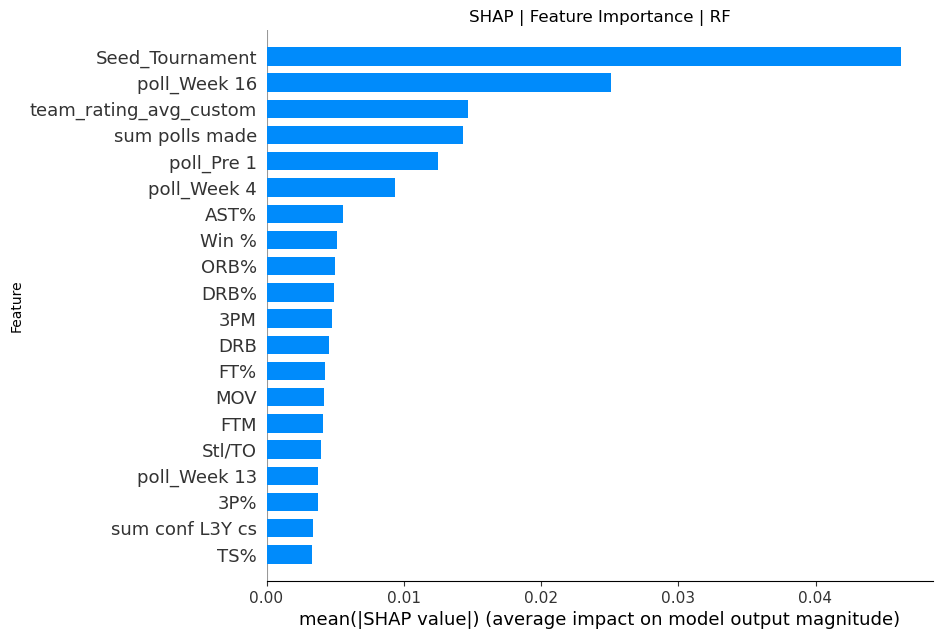

In [264]:
import shap
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np

explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(test[features])

shap.summary_plot(shap_values, test[features], feature_names=features, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Feature Importance | RF')
plt.savefig("rf_shap_bar.png", bbox_inches='tight', pad_inches=0.1)

image = Image.open("rf_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rf_shap_bar.png")

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1]

top_features_list = [features[index] for index in top_features]
print("Top Features:")
print(top_features_list)

plt.ylabel("Feature")
plt.show()

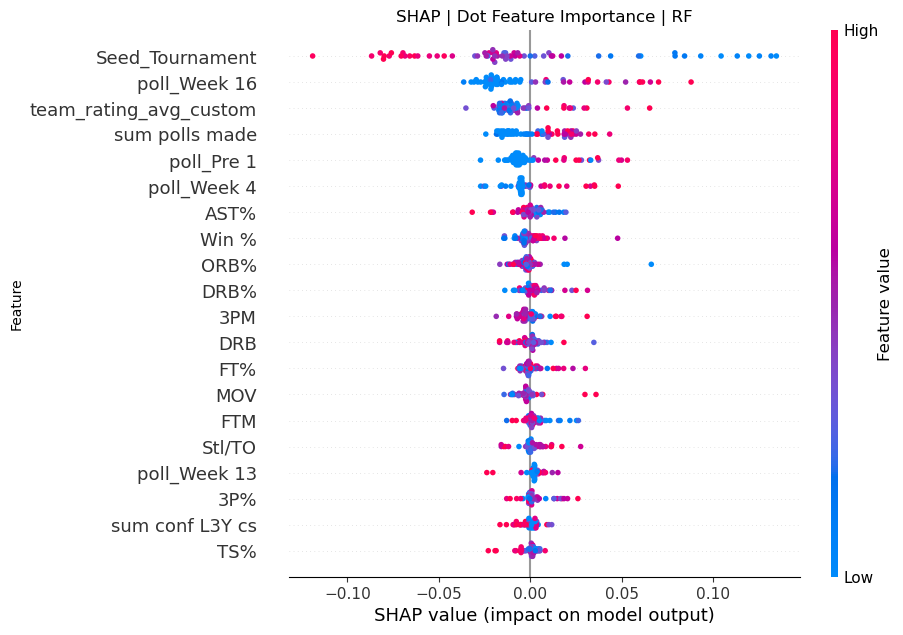

In [265]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(test[features])
shap.summary_plot(shap_values, test[features], feature_names=features, show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Dot Feature Importance | RF')

plt.savefig("rf_shap_dot.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("rf_shap_dot.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rf_shap_dot.png")

plt.ylabel("Feature")
plt.show()